In [1]:
import os
import sys
sys.path.append('../mlai_research/')
import log
import utils
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config("base")

04-Jan-24 09:37:35 - INFO - Starting 'load_config'.
04-Jan-24 09:37:35 - INFO - Finished 'load_config' in 0.0236 secs.


In [3]:
def encode_labels(df, column):
    """
    Encode labels in the specified column of the dataframe.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the labels.
    column (str): The column name of the labels.

    Returns:
    df (pandas.DataFrame): The dataframe with encoded labels.
    """
    label_encoder = preprocessing.LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    return df


def split_data(df, test_size=0.1, val_size=0.1):
    """
    Split the dataframe into training, validation, and testing sets.

    Parameters:
    df (pandas.DataFrame): The dataframe to split.
    test_size (float): The proportion of the dataset to include in the test split.
    val_size (float): The proportion of the training set to include in the validation split.

    Returns:
    train_set (pandas.DataFrame): The training set.
    val_set (pandas.DataFrame): The validation set.
    test_set (pandas.DataFrame): The testing set.
    """
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=42)
    train_set, val_set = train_test_split(train_set, test_size=val_size, random_state=42)
    return train_set, val_set, test_set


def upsample_minorities(df, label_column):
    """
    Upsample the minority classes in the dataframe to match the majority class count.

    Parameters:
    df (pandas.DataFrame): The dataframe to upsample.
    label_column (str): The column name of the labels.

    Returns:
    df_upsampled (pandas.DataFrame): The dataframe with the minority classes upsampled.
    """
    # Get the count of the most frequent class
    majority_class_count = df[label_column].value_counts().max()
    
    # Separate the majority and minority classes
    df_majority = df[df[label_column] == df[label_column].value_counts().idxmax()]
    df_minorities = df[df[label_column] != df[label_column].value_counts().idxmax()]
    
    # List to hold the upsampled dataframes
    upsampled_list = [df_majority]
    
    # Upsample each minority class and add to the list
    for class_index in df_minorities[label_column].unique():
        df_class_minority = df_minorities[df_minorities[label_column] == class_index]
        df_class_upsampled = resample(df_class_minority, 
                                      replace=True, 
                                      n_samples=majority_class_count, 
                                      random_state=42)
        upsampled_list.append(df_class_upsampled)
    
    # Concatenate all upsampled minority class DataFrames with the majority class DataFrame
    df_upsampled = pd.concat(upsampled_list)
    
    return df_upsampled


def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1 score.
    
    Parameters:
    y_true (list): List of true labels
    y_pred (list): List of predicted labels
    
    Returns:
    dict: A dictionary containing the calculated metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


def kappa_confidence_interval(y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    """
    Calculate Cohen's Kappa score with confidence intervals using bootstrapping.
    
    Parameters:
    y_true: Ground truth (correct) target values.
    y_pred: Estimated targets as returned by a classifier.
    n_bootstrap: Number of bootstrap samples to create.
    alpha: Confidence interval, e.g., 0.05 for 95% confidence.
    
    Returns:
    kappa: Cohen's Kappa score
    lower: Lower bound of the confidence interval
    upper: Upper bound of the confidence interval
    """
    # Calculate Cohen's Kappa for the original data
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Generate bootstrap samples and calculate Cohen's Kappa for each sample
    bootstrap_kappas = []
    for _ in range(n_bootstrap):
        y_true_resampled, y_pred_resampled = resample(y_true, y_pred)
        kappa_resampled = cohen_kappa_score(y_true_resampled, y_pred_resampled)
        bootstrap_kappas.append(kappa_resampled)
    
    # Calculate lower and upper percentiles for the confidence interval
    lower = np.percentile(bootstrap_kappas, 100 * alpha / 2)
    upper = np.percentile(bootstrap_kappas, 100 * (1 - alpha / 2))
    
    return kappa, lower, upper



def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot a confusion matrix.
    
    Parameters:
    y_true (list): List of true labels
    y_pred (list): List of predicted labels
    labels (list): List of unique labels
    
    Returns:
    None
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def plot_roc_curve(y_true, y_score, labels):
    """
    Plot a ROC curve.
    
    Parameters:
    y_true (list): List of true labels
    y_score (list): List of predicted scores
    labels (list): List of unique labels
    
    Returns:
    None
    """
    y_true_bin = label_binarize(y_true, classes=labels)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


def self_training(classifier, X_labeled, y_labeled, X_unlabeled, threshold=0.9, max_iter=10):
    """
    Perform self-training with the given classifier.

    Parameters:
    - classifier: a classifier that has fit and predict_proba methods.
    - X_labeled: features of the labeled data.
    - y_labeled: labels of the labeled data.
    - X_unlabeled: features of the unlabeled data.
    - threshold: confidence threshold for labeling unlabeled data.
    - max_iter: maximum number of iterations.

    Returns:
    - The trained classifier.
    """
    classifier = clone(classifier)  # create a new instance of the classifier
    for i in range(max_iter):
        classifier.fit(X_labeled, y_labeled)
        if X_unlabeled.shape[0] == 0:
            break  # no more unlabeled data
        probs = classifier.predict_proba(X_unlabeled)
        max_probs = probs.max(axis=1)
        confident = max_probs > threshold
        if not confident.any():
            break  # no confident predictions
        X_labeled = np.concatenate([X_labeled, X_unlabeled[confident]])
        y_labeled = np.concatenate([y_labeled, probs[confident].argmax(axis=1)])
        X_unlabeled = X_unlabeled[~confident]
    return classifier

# Load Data

In [4]:
df = pd.read_csv(f"{conf.data.path_feat}{conf.data.fn_feat}")
df.shape, df['label'].value_counts()

((327, 1583),
 unk      299
 xan       15
 other     10
 dat        3
 Name: label, dtype: int64)

# Prepare Data 

- Split labelled, unlabelled
- Upsample lower class
- Drop true labels

In [5]:
df_unlabeled = df[df['label'] == 'unk']
df_labeled = df[df['label'] != 'unk']
dflup = upsample_minorities(df_labeled, 'label')
X_labeled = dflup.drop('label', axis=1).values
y_labeled = dflup['label'].values
X_unlabeled = df_unlabeled.drop('label', axis=1).values

# Create classifer

In [6]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train Classifer

In [7]:
classifier = self_training(rf_classifier, X_labeled, y_labeled, X_unlabeled)

In [8]:
y_labeled_pred = classifier.predict(X_labeled)

In [9]:
kappa, lower, upper = kappa_confidence_interval(y_labeled, y_labeled_pred)
print(f"Cohen's Kappa: {kappa}, 95% CI: ({lower}, {upper})")

Cohen's Kappa: 1.0, 95% CI: (1.0, 1.0)


In [11]:
y_labeled

array(['xan', 'xan', 'xan', 'xan', 'xan', 'xan', 'xan', 'xan', 'xan',
       'xan', 'xan', 'xan', 'xan', 'xan', 'xan', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'dat', 'dat',
       'dat', 'dat', 'dat', 'dat', 'dat', 'dat', 'dat', 'dat', 'dat',
       'dat', 'dat', 'dat', 'dat'], dtype=object)

Training data metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


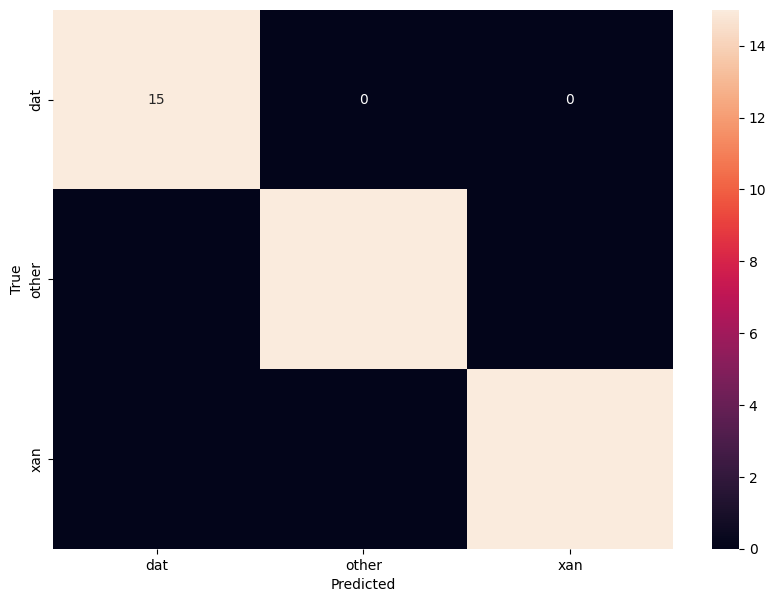

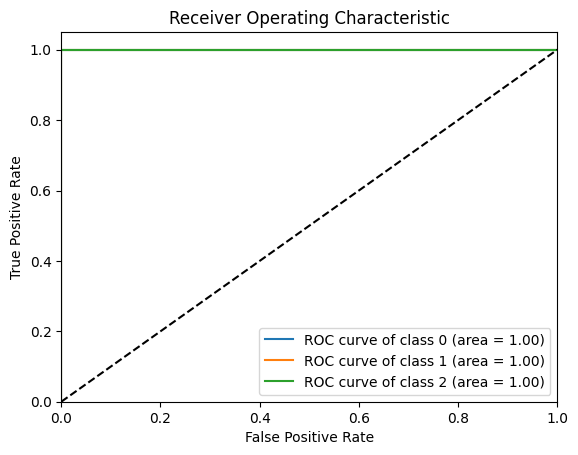

In [10]:
# Plot the confusion matrix and ROC curve of training data
metrics = calculate_metrics(y_labeled, classifier.predict(X_labeled))
print(f'Training data metrics: {metrics}')
plot_confusion_matrix(y_labeled, classifier.predict(X_labeled), classifier.classes_)
plot_roc_curve(y_labeled, classifier.predict_proba(X_labeled), classifier.classes_)

In [ ]:
# Predict the labels of the unlabeled data
y_pred = classifier.predict(X_unlabeled)
y_pred_proba = classifier.predict_proba(X_unlabeled)

# Plot the confusion matrix and ROC curve of the unlabeled data
# calculate_metrics(df_unlabeled['label'], y_pred)
# plot_confusion_matrix(df_unlabeled['label'], y_pred, classifier.classes_)
# plot_roc_curve(df_unlabeled['label'], classifier.predict_proba(X_unlabeled), classifier.classes_)

# Add the predicted labels to the unlabeled data
# df_unlabeled['label'] = y_pred

# # Concatenate the labeled and unlabeled data
# df_concat = pd.concat([dflup, df_unlabeled])

In [ ]:
# drop the label column from columns list:
cols = list(df.columns)
cols.remove('label')
cols.extend(['label_pred_proba', 'label_pred'])

In [ ]:
# combine y_pred and y_pred_proba
y_pred_proba = y_pred_proba.max(axis=1)
y_pred_proba = y_pred_proba.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)
arr_unlabeled = np.concatenate([X_unlabeled, y_pred_proba, y_pred], axis=1)
df_unlabeled = pd.DataFrame(arr_unlabeled, columns=cols)

In [ ]:
df_unlabeled['label_pred'].value_counts()

In [ ]:
df_unlabeled['label_pred_proba'].hist()

In [ ]:
def main():
    df = encode_labels(df, 'label')
    train, val, test = split_data(df)
    train = upsample_minorities(train, 'label')
    X_train = train.drop('label', axis=1).values
    y_train = train['label'].values

    X_val = val.drop('label', axis=1).values
    y_val = val['label'].values

    X_test = test.drop('label', axis=1).values
    y_test = test['label'].values

    # Save as npz files
    np.savez(f"{conf.data.path_mi}{conf.data.fn_train}", X=X_train, y=y_train)
    np.savez(f"{conf.data.path_mi}{conf.data.fn_val}", X=X_val, y=y_val)
    np.savez(f"{conf.data.path_mi}{conf.data.fn_test}", X=X_test, y=y_test)